## What to do
* Familiarize yourself with visualization methods. If mentioned methods in this exercise are not enough you can surely find more methods in scikit-learn. You can see that the methods work but you should understand what they do, may be you can't use them for your data.
* Try to visualize some features of your compounds such as activity, number of carbons, rings etc.
* Show if your compounds with same scaffold are close on your map(s)

## Co dělat
* Seznamte se s vizualizačními metodami. Pokud zmíněné metody v tomto cvičení nestačí, určitě najdete další metody v scikit-learn. Vidíte, že metody fungují, ale měli byste pochopit, co dělají, možná je nebudete moci použít pro svá data.
* Pokuste se vizualizovat některé vlastnosti vašich sloučenin, jako je aktivita, počet uhlíků, prstenů atd.
* Ukažte, zda jsou vaše sloučeniny se stejnými scaffoldy blízko v našich mapách

# Chemický prostor a jeho vizualizace

V předchozích cvičeních jsme získali dovednosti pracovat s molekulami jako objekty v Pythonu a vypočítat pro ně různé deskriptory. Nyní použijeme tato „čísla“ k vizualizaci [chemického prostoru](https://en.wikipedia.org/wiki/Chemical_space) našich ligandů a léků. Určitě jste o tom slyšeli na přednáškách. 

Jednoduše řečeno, když máme čísla, můžeme je promítnout do nějakého grafu. 1024 dimenzionální prostor fingerprintů je však příliš mnoho na to, abychom tam našli něco rozumného. Jako cvičení mysli si zkuste představit 4D nebo 5D graf. V tomto cvičení nicméně připravíme několik map pro naše sloučeniny. Použijeme některé deskriptory, fingerprinty a ke snížení počtu dimenzí [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_ne Neighbor_embedding). Tyto nástroje jsou velmi populární a snadno o nich najdete mnoho článků. A ano, používáme je také.

Co tedy budeme potřebovat k vizualizaci našich dat? Samozřejmě RDKit a něco k vykreslení (Seaborn, Matplotlib nebo co chcete). Něco pro práci s naším číselným prostorem, používám scikit-learn a spolu s ním také trénujeme model.

In [13]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import numpy as np
import csv
import re

## Data preparation

In [2]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [3]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [62]:
raw_df = pd.read_csv('data/cyclooxygenase_1.csv', sep=';') 

# odstraneni dat, ktere nemaji IC50 nebo maji jinou jednotku nez nM,
# tim se odstrani data, ktere nemaji Smiles
df_cox = raw_df[(raw_df['Standard Units'] == 'nM')]

# vytvoreni danych features, ktere budeme pozdeji vyuzivat
df_cox['rdmol'] = df_cox['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df_cox['source'] = 'cox1'
df_cox['pChEMBL_value'] = df_cox['pChEMBL Value'].apply(lambda x: float(x) if float_pattern.match(str(x)) else 0)
df_cox['fps'] = df_cox['rdmol'].apply(lambda x:Chem.GetMorganFingerprintAsBitVect(x,2,nBits=1024))

for f in lip_func:
        df_cox[f[0]] = df_cox['rdmol'].apply(lambda x: f[1](x))

df_cox = df_cox[["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)]]
df_cox.head()

/home/simik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/simik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/simik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Smiles source  \
0      COc1ccc(/C=N/c2ccc(S(N)(=O)=O)cc2)cc1O   cox1   
1      COc1cc(/C=N/c2ccc(S(N)(=O)=O)cc2)ccc1O   cox1   
2         Nc1ccc(C(=O)Nc2ccc(C(F)(F)F)cc2)nc1   cox1   
3  COc1ccc(-c2noc(CC(=O)O)c2-c2ccc(OC)cc2)cc1   cox1   
4  CS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1   cox1   

                                              rdmol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f8647e07670>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f8647e07710>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f8647e078f0>   
3  <rdkit.Chem.rdchem.Mol object at 0x7f8647e07580>   
4  <rdkit.Chem.rdchem.Mol object at 0x7f8647e07530>   

                                                 fps  pChEMBL_value  HBA  HBD  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           4.36    5    2   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           4.11    5    2   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    3    2   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           8.85    5    1   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           4.94    4    0   

           MW    LogP    TPSA  RB  
0  306.067428  1.7988  101.98   4  
1  306.067428  1.7988  101.98   4  
2  281.077597  2.9349   68.01   2  
3  339.110673  3.6529   81.79   6  
4  314.061280  2.5577   60.44   3

In [39]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [83]:
# let's work with Pandas dataframe        
df = pd.DataFrame((drugbank), columns = ["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df = df.append(df_cox)
df.reset_index(level=0, inplace=True,drop=True)
df

Smiles    source  \
0      CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1      CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2      N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3      CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4      C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   
...                                                  ...       ...   
10303        COc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(Cl)cc2)cc1      cox1   
10304  Cc1ccc(-n2nc(COC(=O)COc3cc(O)c4c(=O)cc(-c5cccc...      cox1   
10305       CC(C)(C)C1=NN(c2ccc(C(=O)O)cc2)C(c2ccccc2)C1      cox1   
10306  CC(C)(C)C1=NN(c2ccc(S(=O)(=O)O)cc2)C(c2ccc(F)c...      cox1   
10307          CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O      cox1   

                                                  rdmol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7f865fd56670>   
1      <rdkit.Chem.rdchem.Mol object at 0x7f8660512ee0>   
2      <rdkit.Chem.rdchem.Mol object at 0x7f865fd56c10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7f865fd56120>   
4      <rdkit.Chem.rdchem.Mol object at 0x7f865fd56490>   
...                                                 ...   
10303  <rdkit.Chem.rdchem.Mol object at 0x7f8647b890d0>   
10304  <rdkit.Chem.rdchem.Mol object at 0x7f8647b89120>   
10305  <rdkit.Chem.rdchem.Mol object at 0x7f8647b89170>   
10306  <rdkit.Chem.rdchem.Mol object at 0x7f8647b89210>   
10307  <rdkit.Chem.rdchem.Mol object at 0x7f8647b89260>   

                                                     fps  pChEMBL_value  HBA  \
0      [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   29   
1      [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
2      [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   15   
3      [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
4      [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   12   
...                                                  ...            ...  ...   
10303  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           7.28    3   
10304  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           4.30    8   
10305  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    3   
10306  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    4   
10307  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           4.07    5   

       HBD           MW     LogP    TPSA  RB  
0       28  2178.985813 -8.11643  901.57  66  
1       17  1268.641439 -3.10570  495.89  31  
2       14  1068.426955 -4.13203  435.41  19  
3       17  1429.669818 -0.50613  495.67  38  
4        5  1201.841368  3.26900  278.80  15  
...    ...          ...      ...     ...  ..  
10303    0   352.059025  5.22010   27.05   3  
10304    1   592.140114  7.10232  103.79   8  
10305    1   322.168128  4.73830   52.90   3  
10306    1   376.125692  4.42590   69.97   3  
10307    2   331.062677  1.58100   99.60   2  

[10308 rows x 11 columns]

## Společné grafy
Načetli jsme data a můžeme je vizualizovat v nějakém grafu. Mimo soutěž, kolik kombinací našich 6 deskriptorů máme a můžeme si je zobrazit?

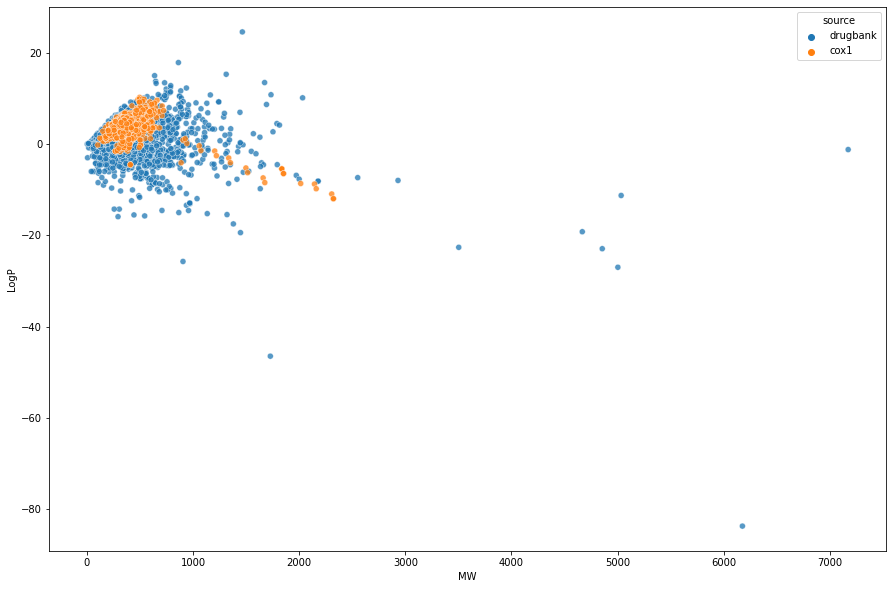

In [84]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

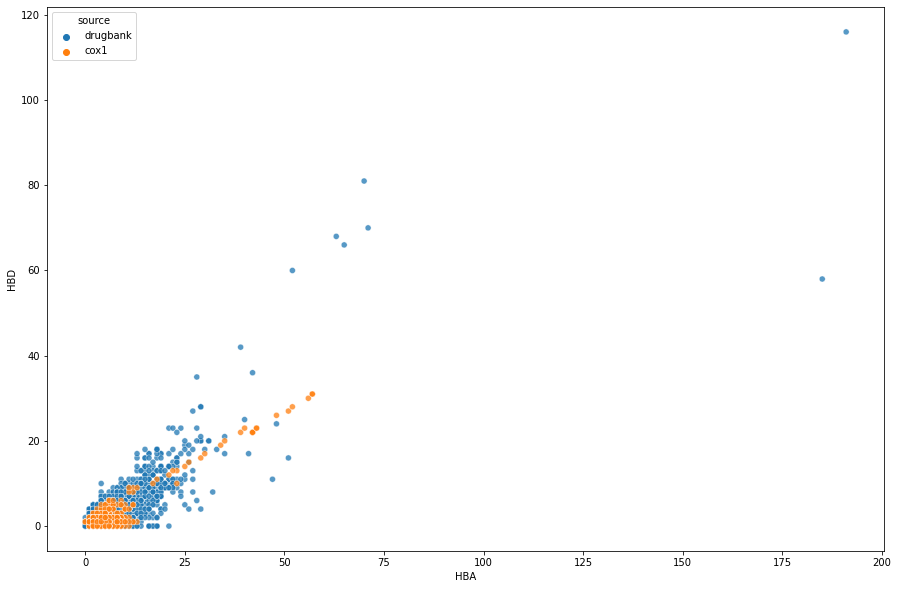

In [85]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Co byste řekli na použití nějaké zavedené mírně větší sady deskriptorů? Například [MQNs](https://dx.doi.org/10.1021/cn3000422). Neznáš to? Viděli jste obrázek na stránce Chemický prostor na Wikipedii? Je to 42 chemických deskriptorů, jako je počet uhlíků, dusíku, kruhů, dvojných vazeb, dárců atd. Můžete hádat, co vynesená čísla znamenají.

In [86]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

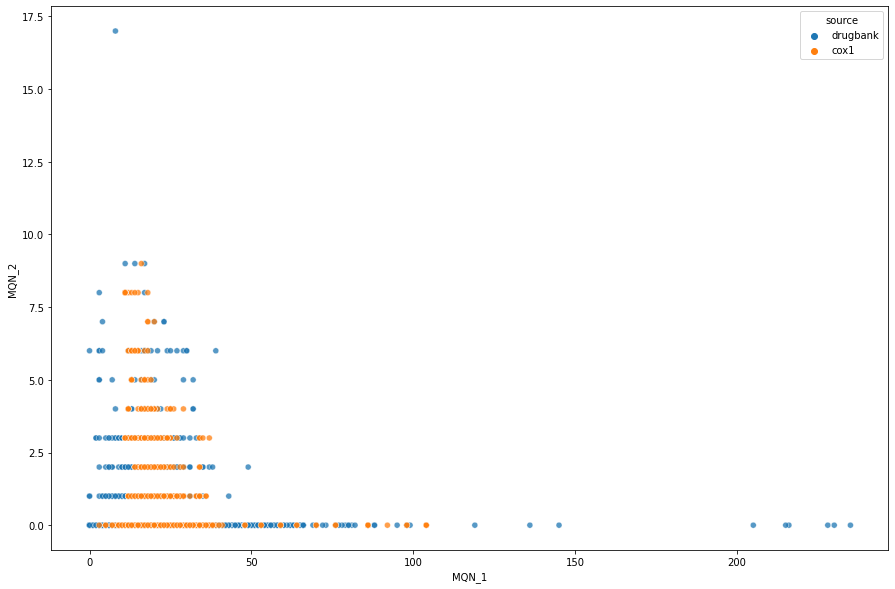

In [87]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## PCA
První metodou, kterou používáme ke snížení počtu rozměrů, je PCA. Samotné PCA mění pouze koordinační systém, takže by nám to nepomohlo, ale má zvláštní schopnost, že komponenty jsou seřazeny tak, jak první komponenta popisuje největší rozdíly v datech, ostatní postupně méně. Pokud tedy vezmeme první dvě složky, získáme co nejvíce informací.

In [88]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
df = df.join(pd.DataFrame(pca.transform(df[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

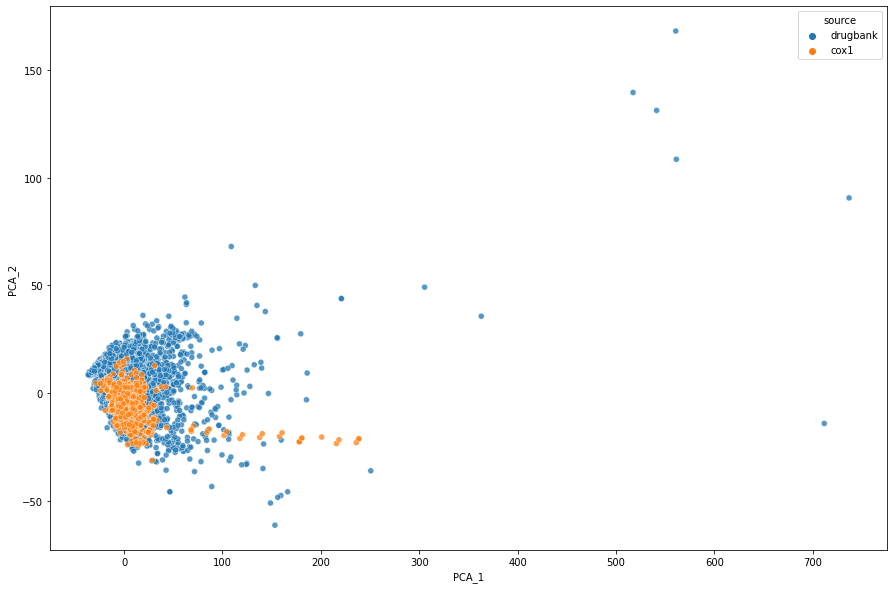

In [89]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Vypadá to dobře, ale ... pamatujete si větu o rozptylu a PCA? Když některé variabilně vynásobíme 100, jejich rozptyl se také vynásobí 100. Můžete tedy chtít [normalizovat](https://en.wikipedia.org/wiki/Normalization_ (statistika)) (nebo udělat něco podobného ) všechny proměnné, aby byly srovnatelné.

In [90]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

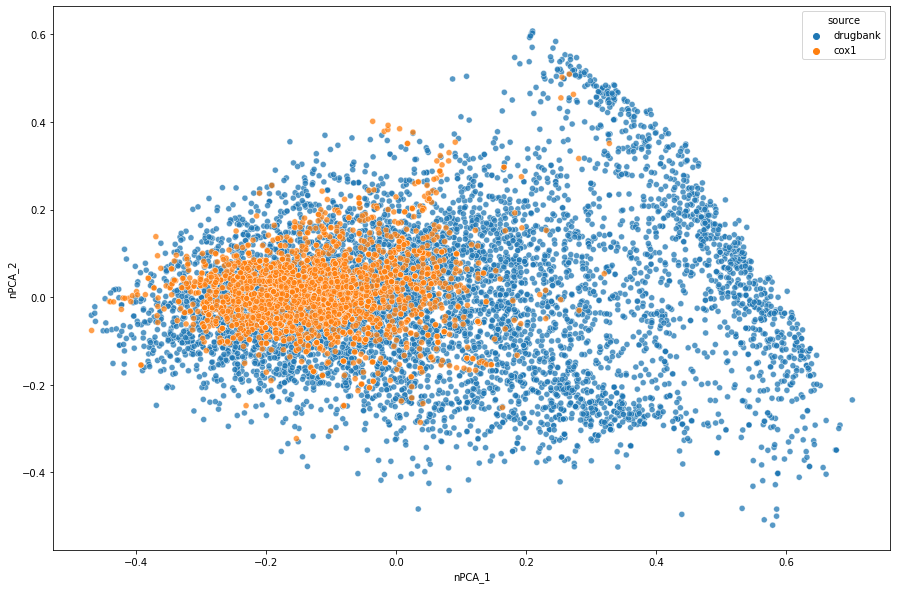

In [91]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## MDS
[Multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) umístí instance do prostoru nižší dimenze (obvykle 2D / 3D). Metoda je iterativní a snaží se udržovat podobné vzdálenosti mezi body v původním a novém prostoru.

In [93]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [94]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

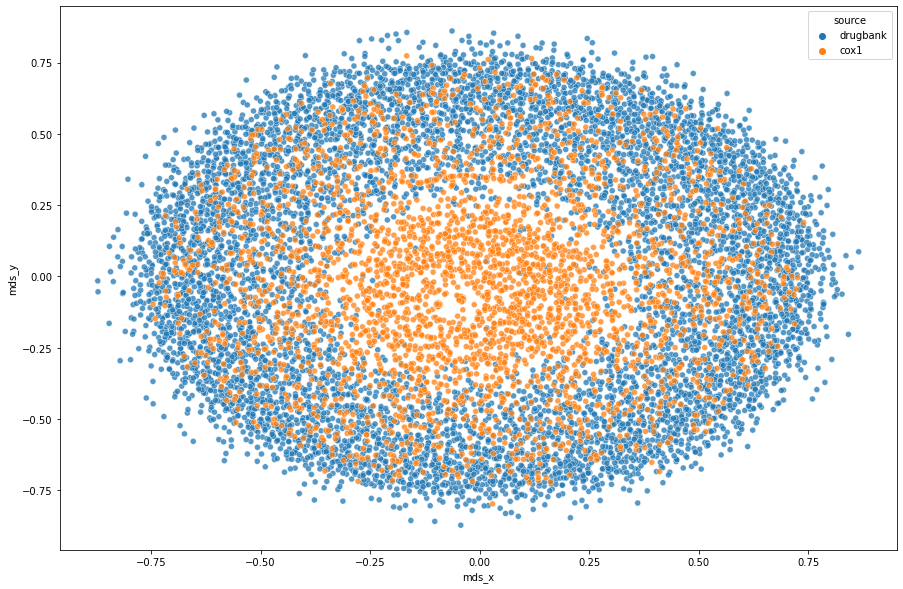

In [95]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## t-SNE
[t-distribuované stochastické vkládání sousedů](https://en.wikipedia.org/wiki/T-distributed_stochastic_ne Neighbor_embedding) je další populární metoda k zobrazování podobných instancí blízko sebe a nepodobně daleko. Můžeme recyklovat vzdálenosti vypočítané pro MDS.

In [96]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

/home/simik/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [97]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

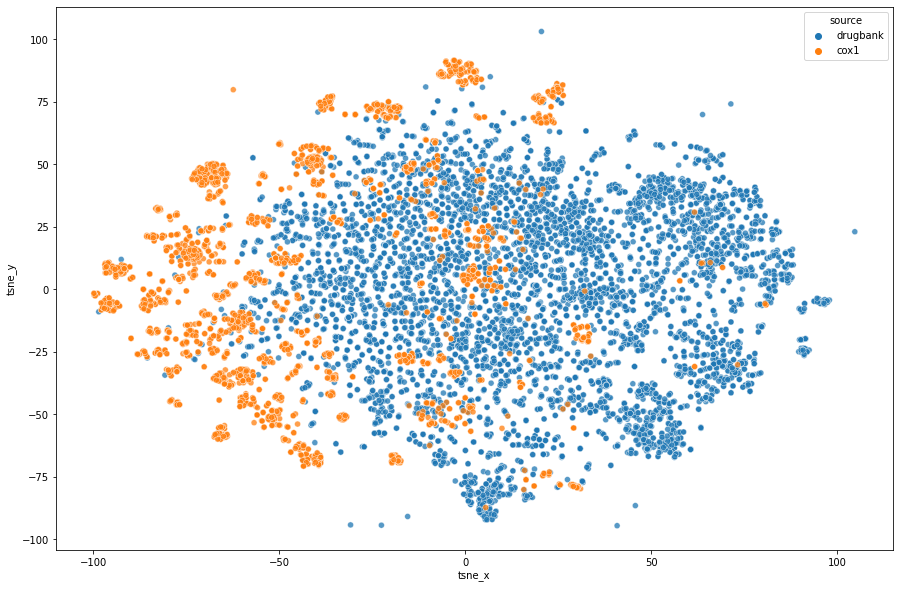

In [98]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## How can we use it?
### Use case 1: Diversity picker

In [99]:
def distance_function(index1, index2, *args, fingerprints=df["fps"],
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [100]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45))
df["picked"] = df.index.isin(picked)

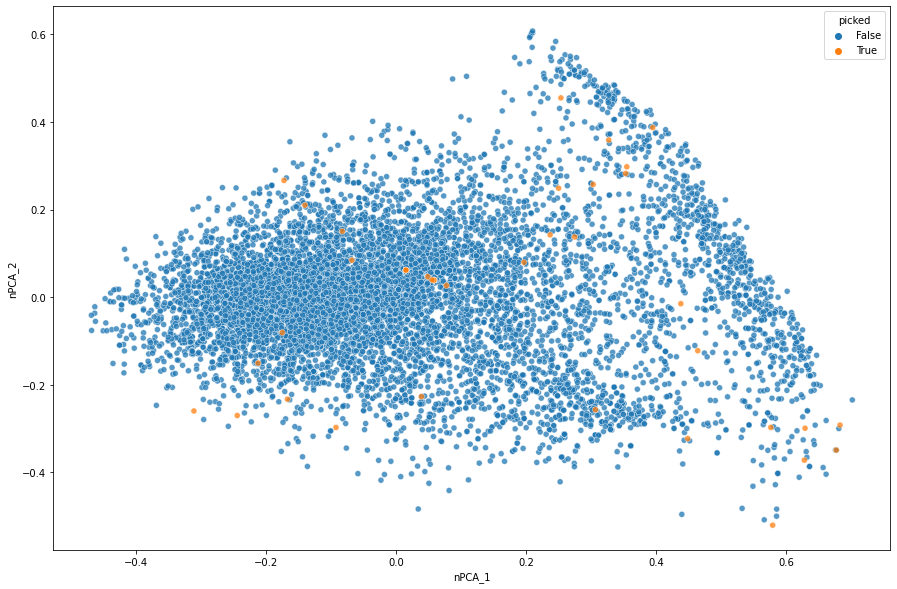

In [101]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

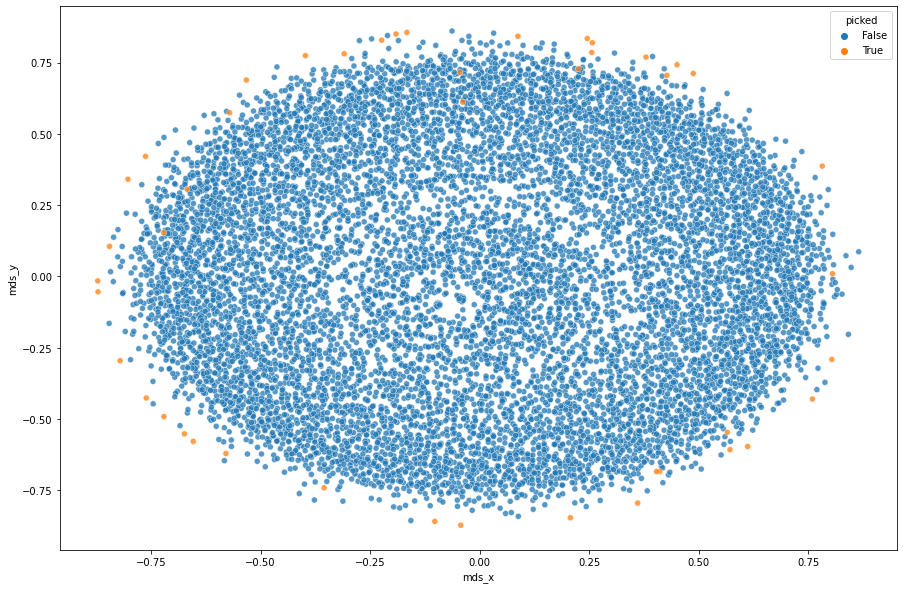

In [102]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

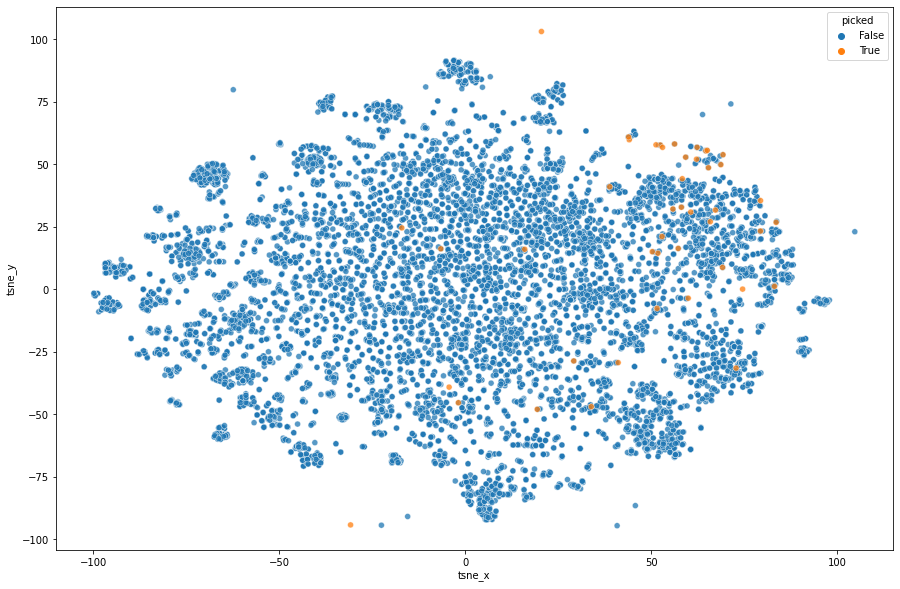

In [103]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

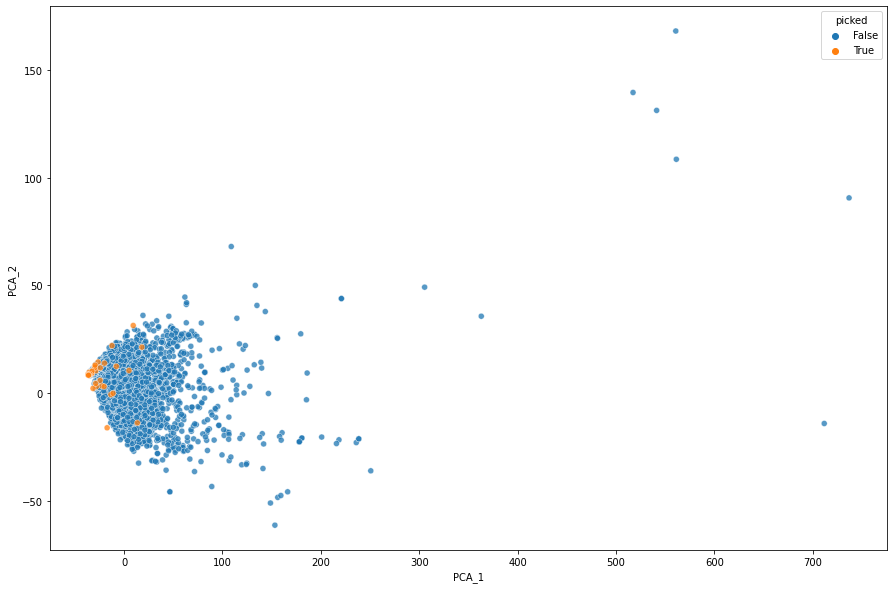

In [104]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1",
                      y="PCA_2",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Alespoň podle MDS a mírně podle t-SNE můžeme vidět naše práce na výběr rozmanitosti. PCA samozřejmě nebyl trénován na fingerprinty, takže o tom nemůžeme moc říct.

### Use case 2: Activities or descriptors

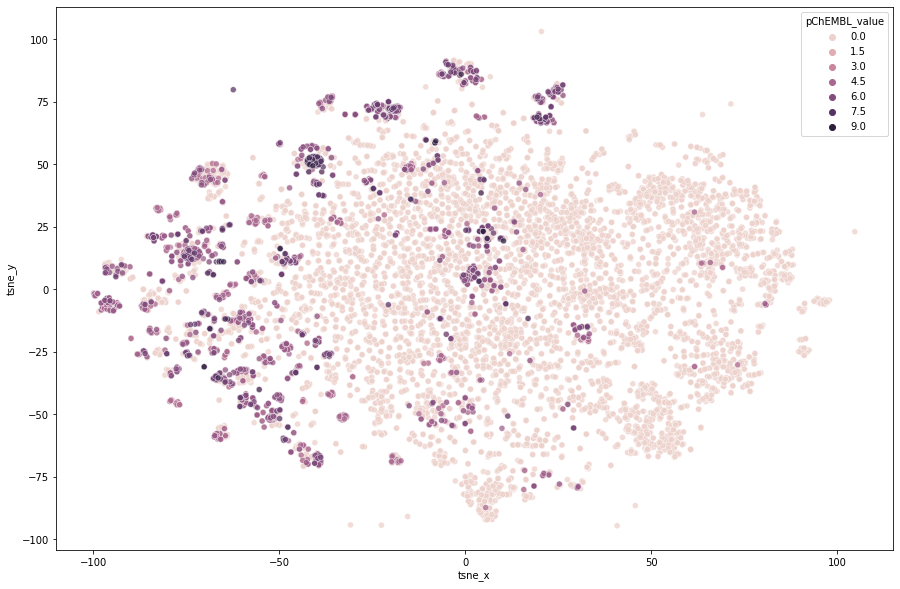

In [105]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

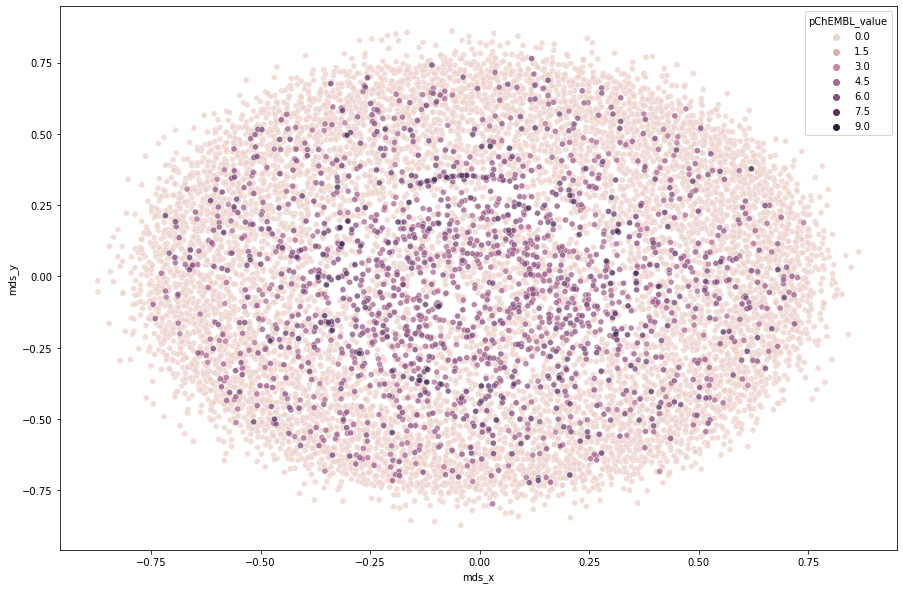

In [106]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

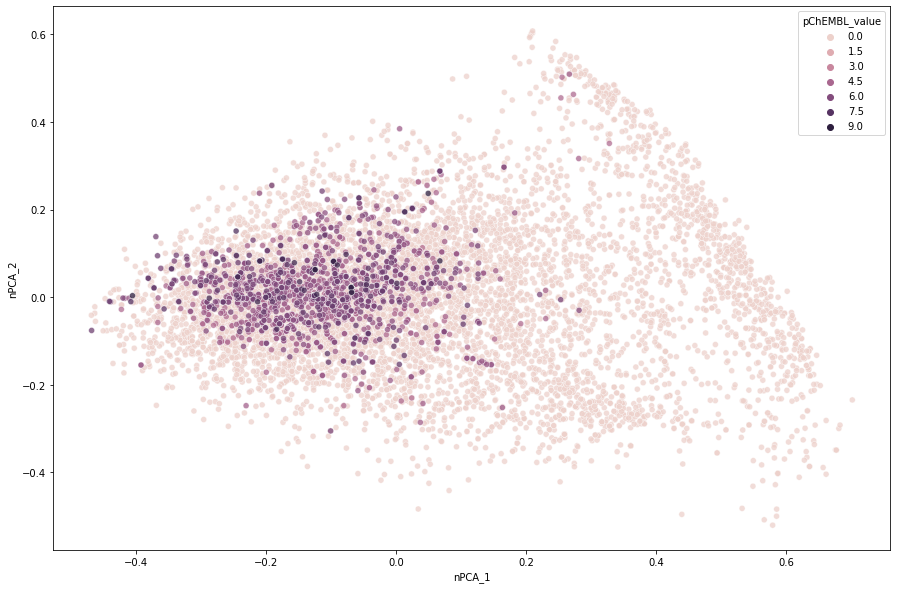

In [107]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

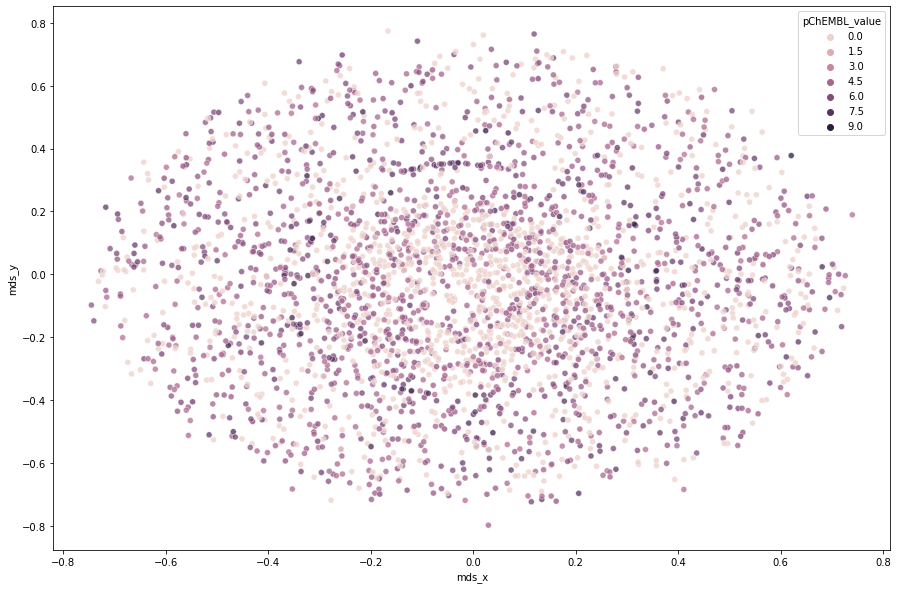

In [108]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df[df.source == "cox1"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

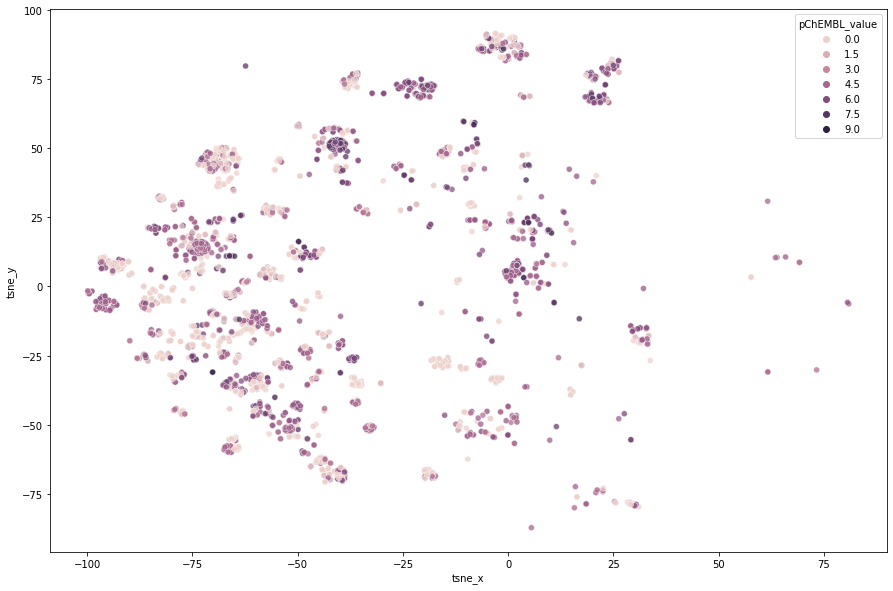

In [109]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df[df.source == "cox1"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

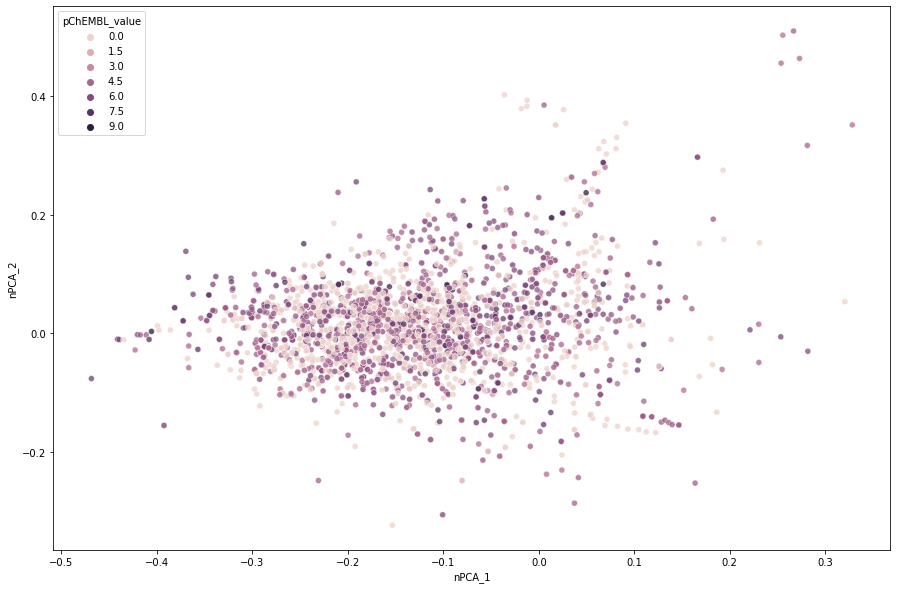

In [110]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "cox1"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )